# Practical machine learning and deep learning. Lab 7

# Semantic Segmentation

# [Competition](https://www.kaggle.com/t/2e9beb0e06634b03b0e0256ea493146f)

## Goal

The goal of the lab is to implement an AE-like model for structural material semantic segmentation. To simplify the task, only concrete segmentation should be performed.

## Submission

Submission format is described at competition page.


## Semantic segmentation

Semantic segmentation is a deep learning algorithm that associates a label or category with every pixel in an image.


In [198]:
# necessary imports
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from pathlib import Path
from torch.utils.data import random_split
import torch.nn as nn
import cv2
import torch.nn.functional as F
from tqdm import tqdm

In [199]:
# necessary constants
CLASS_MAPPING = {
    0: "background",
    1: "steel",
    2: "concrete",  # target category - segment concrete
    3: "metal deck",
}
COLOR_MAPPING = {
    0: (0, 0, 0),
    1: (0, 0, 128),
    2: (0, 128, 0),
    3: (0, 128, 128),
}


color2label = {v: k for k, v in COLOR_MAPPING.items()}
IMG_SIZE = 256
MAX_PIXEL_VALUE = 255
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

## Dataset


In [200]:
train_dir = "/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/train"

### Preprocessing

For the following lab we will use [Albumentations](https://albumentations.ai/) for the data transforms. Albumentations allows image and mask transformation at the same time.


In [201]:
transforms = A.Compose(
    [
        A.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD, max_pixel_value=MAX_PIXEL_VALUE),
        ToTensorV2(transpose_mask=True)
    ]
)

### Dataset class


In [202]:
import os
from keras.utils.np_utils import to_categorical   

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root_path: Path, transform):
        """
        Material segmentation dataset

        :param root_path: path to train split, which contains images and masks
        :param transform: transforms for dataset

        """
        self.transform = transform
        if not root_path.exists():
            raise FileNotFoundError(f"No root path {root_path} was found")
        self.img_path = root_path / "images"
        self.mask_path = root_path / "masks"

        if not self.img_path.exists():
            raise FileNotFoundError("No images was found")

        if not self.mask_path.exists():
            raise FileNotFoundError("No masks was found")

        # create list of images and masks
        self.img_list = sorted(self._get_filenames(self.img_path))[:]
        self.mask_list = sorted(self._get_filenames(self.mask_path))[:]
        
        for i,z in zip(self.img_list, self.mask_list):
            if os.fspath(i).split('/')[-1][:-4] != os.fspath(z).split('/')[-1][:-3]: print(i, z)

        missing_files = set([f.stem for f in self.img_list]).symmetric_difference(
            set([f.stem for f in self.mask_list])
        )
        if len(missing_files) != 0:
            raise FileNotFoundError(f"Missing files: {missing_files}")

        # load images and masks into memory
        self._read_masks()
        self._read_imgs()
        

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        transformed = self.transform(image=img, mask=mask)
        return transformed["image"].float(), transformed["mask"].float()

    def __len__(self):
        return len(self.img_list)

    def _get_filenames(self, path):
        return [f for f in path.iterdir() if f.is_file()]
    

    def _read_imgs(self):
        """
        Load images into memory
        """
        self.images = [cv2.resize(cv2.imread(os.fspath(image)), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) for image in self.img_list]

    def _read_masks(self):
        """
        Load masks into memory and convert multiclass mask
        into binary masks for 'concrete' class
        """
        self.masks = []
        for i, mask in enumerate(self.mask_list):
            
            m = cv2.resize(cv2.imread(os.fspath(mask)), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
            m = cv2.inRange(m, lowerb=COLOR_MAPPING[2], upperb=COLOR_MAPPING[2]).T/MAX_PIXEL_VALUE
#             print(m.shape, m.dtype)
#             print(m[:5,:5])
            m = to_categorical(m, num_classes=2).astype(np.float64)
#             print(m.shape, m.dtype)
#             print(m[1,:5,:5])
            
            
#             print(m.sum())
            
            self.masks.append(m)
            
        


In [203]:
dataset = SegmentationDataset(Path(train_dir), transform=transforms)

# splitting dataset into train and validation
split_proportion = 0.9
size = int(len(dataset) * split_proportion)
train_dataset, val_dataset = random_split(dataset, [size, len(dataset) - size])


In [204]:
# create dataloaders
batch_size = 8
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [205]:
# check the sizes of train and validation splits
len(train_dataset), len(val_dataset)


(3092, 344)

## Model

U-Net is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. Every step in the expansive path consists of an upsampling of the feature map, a concatenation with the correspondingly cropped feature map from the contracting path, and convolutions.

### Architecture

<!-- ![Alt text](unet.png) -->
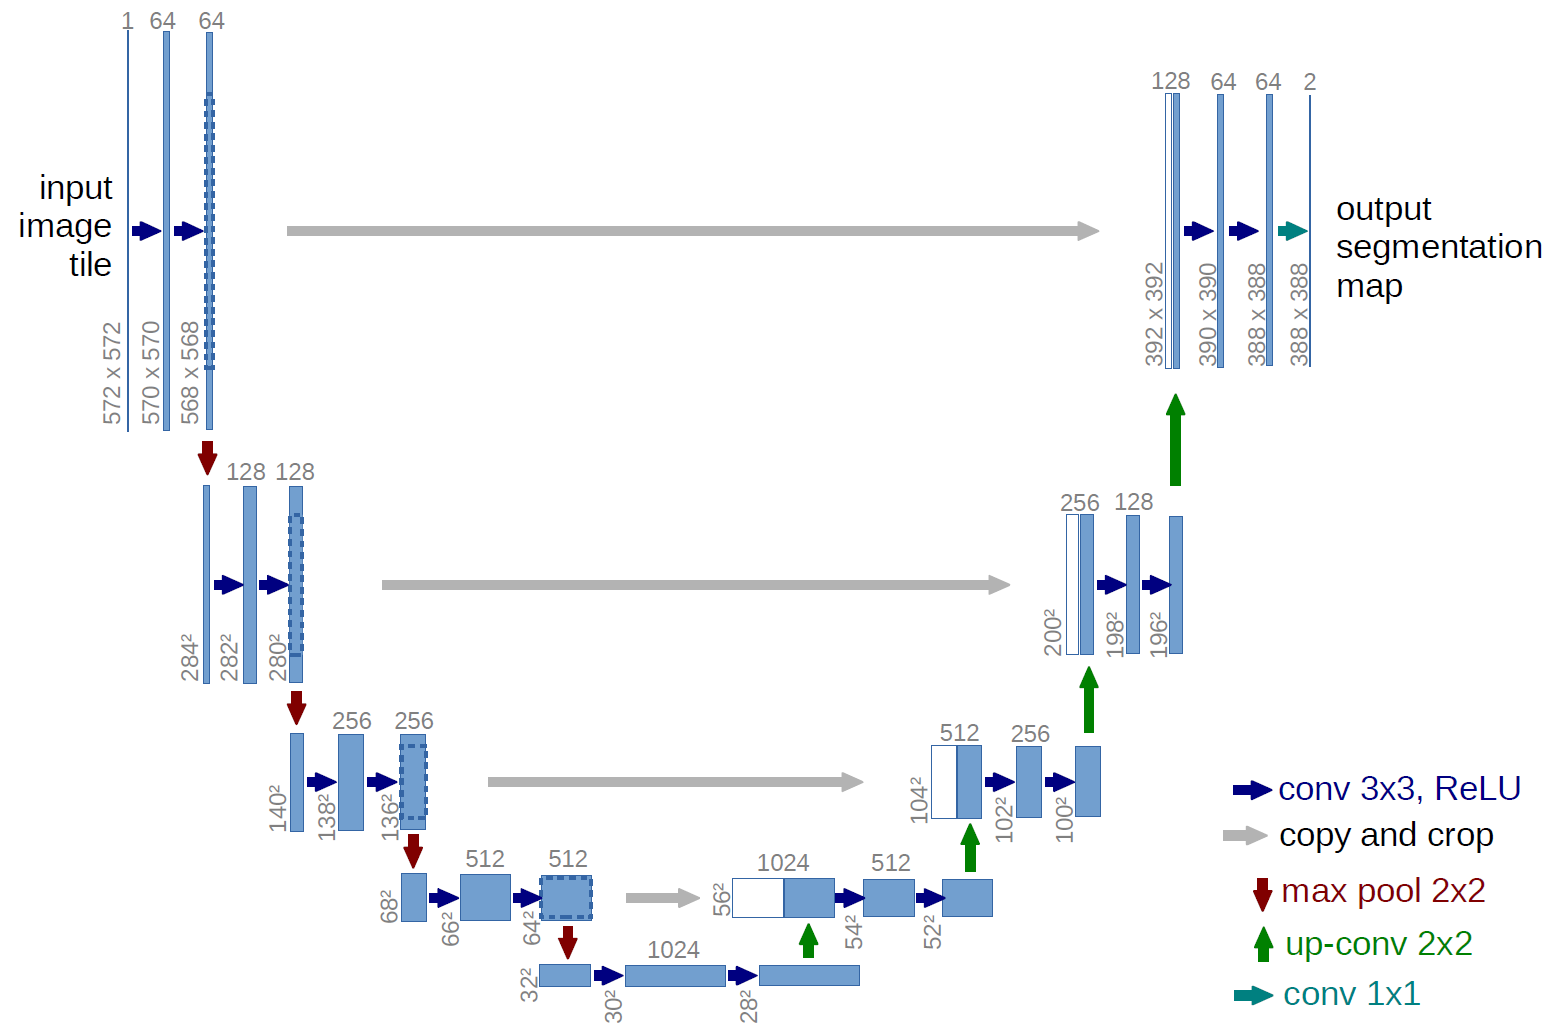

In [206]:
class DoubleConv(nn.Module):
    """
    Block with two convolutional blocks
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        """
        Double convolution

        :param in_channels: number of in channels for first conv layer
        :param out_channels: number of out channels for last conv layer
        :param mid_channels: number of out channels for first conv layer
        """
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        # write model that contains 2 conv layer with batch normalization and relu activation function
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """
    Block for down path
    """

    def __init__(self, in_channels, out_channels):
        """
        Down block

        :param in_channels: number of in channels for double conv block
        :param out_channels: number of out channels for double conv block
        """
        super().__init__()

        # write model which contains pooling and double conv block
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Block for up path
    """

    def __init__(self, in_channels, out_channels):
        """
        Down block

        :param in_channels: number of in channels for transpose convolution
        :param out_channels: number of out channels for double conv block
        """
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Final convolution block

        :param in_channels: number of in channels for conv layer
        :param out_channels: number of out channels for conv layer
        """
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [207]:
class UNet(nn.Module):
    """
    UNet model
    """

    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
        self.m = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.inc(x)
#         print(x1.size())
        x2 = self.down1(x1)
#         print(x2.size())
        x3 = self.down2(x2)
#         print(x3.size())
        x4 = self.down3(x3)
#         print(x4.size())
        x5 = self.down4(x4)
#         print(x5.size())
#         print(x5.size(), x4.size(), self.up1)
        x = self.up1(x5, x4)
#         print(x.size())
        x = self.up2(x, x3)
#         print(x.size())
        x = self.up3(x, x2)
#         print(x.size())
        x = self.up4(x, x1)
#         print(x.size())
        logits = self.outc(x)
#         print(logits.size())
#         print(logits[0,:,0,0])
        m = self.m(logits)
#         print(m[0,:,0,0])
        return m

## Loss

As the loss we will use combination of Cross Entropy Loss and Dice Loss

### Dice loss

Dice loss is based on [Sørensen-Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient). It measures the overlap between the predicted and target segmentation masks. Dice loss provides a differentiable and smooth measure of segmentation accuracy.

$$
DiceLoss\left( y, \overline{p} \right) = 1 - \dfrac{\left(  2y\overline{p} + 1 \right)} {\left( y+\overline{p } + 1 \right)}
$$


In [208]:
import torch.nn.functional as F
class DiceLoss(nn.Module):
    """
    Dice loss
    """

    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, eps=1e-6):
        """
        Calculation of dice loss

        :param inputs: model predictions
        :param targets: target values
        :param eps: stability factor, defaults to 1e-6
        :return: loss value
        """
#       
#         targets = torch.nn.functional.one_hot(targets, num_classes=2).permute(0,3,1,2)
#         mul = (torch.abs(inputs[:, 1]) + torch.abs(inputs[:, 0])).sum()
#         print(targets[:20,:,128,128])
#         mul = (targets * inputs).sum(1).sum(1).sum(1)
#         sumI = (inputs).sum(1).sum(1).sum(1)
#         sumT = (targets).sum(1).sum(1).sum(1)
#         print(inputs.type(), targets.type())
#         print(inputs.size(), targets.size())
#         inputs = F.softmax(inputs, dim=1)
    

#         for i in range(targets.size(0)):
        mul = (targets * inputs).sum(axis=[1,2, 3])
        sumI = (inputs**2).sum(axis=[1,2, 3])
        sumT = targets.sum(axis=[1,2, 3])
        
        dice = (2 * mul + eps) / (sumI + sumT + eps)
#         print(sumT.size(), dice.size())
#         print(mul.item(), sumI.item(), sumT.item(), dice.item())
        dice = torch.mean(dice, axis=0)
        return 1-dice



In [209]:
model = UNet(n_channels=3, n_classes=2)

In [210]:
optimizer = torch.optim.Adam(
    model.parameters(),
)
criterion1 = nn.CrossEntropyLoss(reduction="mean")
# criterion1 = nn.BCELoss()
criterion2 = DiceLoss()


## Training


In [211]:
def train_model(model, train_loader, val_loader, device, optimizer, epochs=1, best_loss=1000, dice=[]):
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        train_loss=0
        with tqdm(
            total=len(train_dataset), desc=f"Epoch {epoch}/{epochs}", unit="img"
        ) as pbar:
            for i, batch in enumerate(train_loader):
                images, true_masks = batch
                images, true_masks = images.to(device), true_masks.to(device)
                
#                 plt.subplot(211)
#                 plt.imshow(images.cpu().permute(0,2,3,1)[0])
#                 plt.subplot(212)
#                 plot_mask(true_masks[0].cpu().numpy().reshape(256,256))
#                 raise Exception()

                masks_pred = model(images)
                dice_loss = criterion2(masks_pred, true_masks)
                dice.append(dice_loss)
                loss = criterion1(masks_pred, true_masks) + dice_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                pbar.update(images.shape[0])
                train_loss += loss.item()
                pbar.set_postfix(**{"loss (batch)": loss.item(), "avg loss": train_loss/(i+1)})
        model.eval()
        with tqdm(total=len(val_dataset), desc=f"Validation", unit="img") as pbar:
            with torch.no_grad():
                for i, batch in enumerate(val_loader):
                    images, true_masks = batch

                    images, true_masks = images.to(device), true_masks.to(device)

                    masks_pred = model(images)
                    loss = criterion1(masks_pred, true_masks) + criterion2(
                        masks_pred, true_masks
                    )
                    pbar.update(images.shape[0])
                    epoch_loss += loss.item()
                    pbar.set_postfix(**{"loss (batch)": loss.item(), "avg loss": epoch_loss/(i+1)})
        if (epoch_loss < best_loss):
            print('SAVED MODEL')
            torch.save(model.state_dict(), "best.pt")
            best_loss = epoch_loss


In [ ]:
dice_hist = []
train_model(model, train_loader, val_loader, "cuda", optimizer, epochs=100, dice=dice_hist)


Validation: 100%|██████████| 344/344 [00:03<00:00, 94.14img/s, avg loss=0.896, loss (batch)=0.999]


SAVED MODEL


Validation: 100%|██████████| 344/344 [00:03<00:00, 93.93img/s, avg loss=0.869, loss (batch)=0.937]


SAVED MODEL


Epoch 3/100:  84%|████████▎ | 2584/3092 [01:14<00:14, 34.52img/s, avg loss=0.862, loss (batch)=0.834]

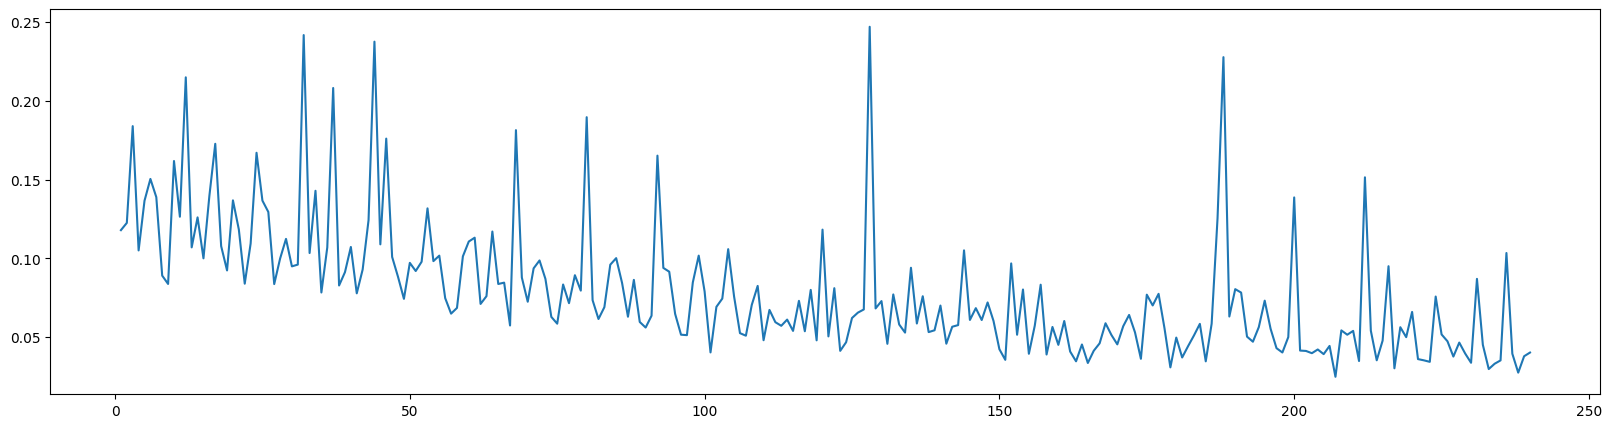

In [136]:
hist = [d.cpu().detach().numpy() for d in dice_hist[::5]]
plt.figure(figsize=(20,5))
plt.plot(list(range(1, len(hist) + 1)),hist)

In [137]:
torch.save(model.state_dict(), "best_train_small.pt")


## Predict


In [138]:
import matplotlib.pyplot as plt


def plot_mask(mask, color_mapping=COLOR_MAPPING):
    color_mask = np.zeros((*mask.shape[::-1], 3), dtype=np.uint8)
    for i in range(mask.shape[1]):
        for j in range(mask.shape[0]):
            color_mask[i, j] = color_mapping[mask[j, i]]
    color_mask = cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB)
    plt.imshow(color_mask)


In [139]:
test_transforms = A.Compose(
    [
        A.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD, max_pixel_value=MAX_PIXEL_VALUE),
        ToTensorV2()
    ]
)


In [140]:
SUBMISSION_SHAPE = (64, 64)


def predict(model, img, device="cpu"):
    """
    Model inference on image

    :param model: model
    :param img: image
    :param device: device for computation, defaults to "cpu"
    :return: mask
    """
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    tensor_img = test_transforms(image=img)['image']
    tensor_img = tensor_img.to(device=device, dtype=torch.float32).unsqueeze(0)
    #print(tensor_img.size())

    plt.imshow(tensor_img.permute(0,2,3,1).detach().cpu()[0])
    
    with torch.no_grad():
        output = model(tensor_img)
        mask = torch.argmax(output, axis=1)
    
    mask = mask.detach().cpu().numpy()[0].astype(np.uint8)
    mask = cv2.resize(mask, SUBMISSION_SHAPE, interpolation=cv2.INTER_NEAREST)
    return mask


torch.Size([2, 256, 256])


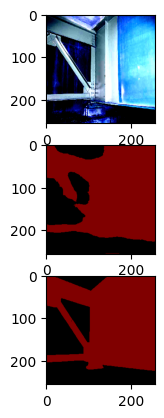

In [155]:
for i, batch in enumerate(train_loader):
    images, true_masks = batch[0].to('cuda'), batch[1].to('cuda')
    i = 5
    o = model(images[i:i+1])[0] # only one image
    print(o.shape)
    mask = torch.argmax(o, axis=0).detach().cpu().numpy()
    plt.subplot(311)
    plt.imshow(images[i:i+1][0].permute(1,2,0).detach().cpu().numpy())
    plt.subplot(312)
    plot_mask(mask)
    plt.subplot(313)
    plot_mask(np.argmax(true_masks[i:i+1][0].permute(1,2,0).detach().cpu().numpy(),axis=2))
    break

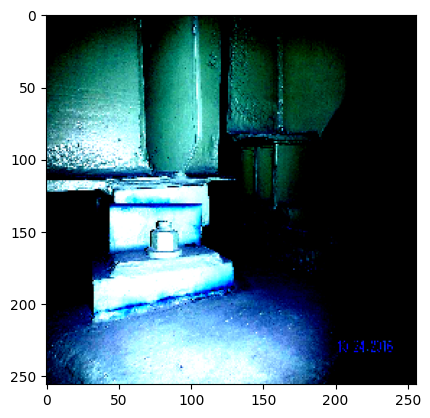

In [157]:
plt.imshow(dataset[0][0].permute(1,2,0))

torch.Size([2, 256, 256]) torch.Size([3, 256, 256])
/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/train/masks/1001.png


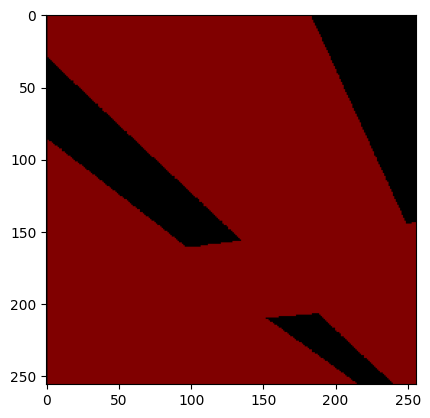

In [194]:
print(dataset[0][1].shape, dataset[0][0].shape)
i = 5
print(dataset.mask_list[i])
plot_mask(np.argmax(dataset[i][1].numpy(),axis=0))

/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/train/images/1001.jpeg


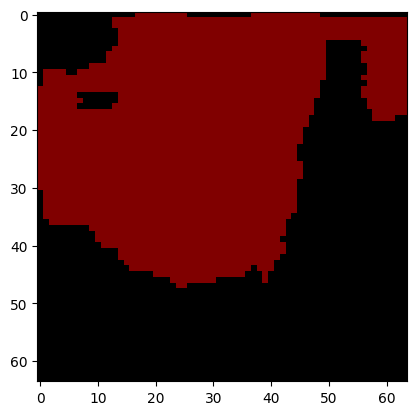

In [197]:
print(f"{os.fspath(dataset.mask_list[i])[:-3]+'jpeg'}".replace('masks', 'images'))
img = cv2.imread(
#     f"{os.fspath(dataset.mask_list[i])[:-3]+'jpeg'}".replace('masks', 'images')
    "/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/test/images/0.jpeg"
)
model.to('cuda')
mask = predict(model, img, device='cuda')
plot_mask(mask)


## Submission


In [100]:
def rle_encode(x, fg_val=1):
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    if x:  # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = "-"
    return s

In [31]:
model = UNet(n_channels=3, n_classes=2)
model.load_state_dict(torch.load("best_train.pt"))
model.to('cuda')
model.eval()
2

2

In [101]:
import gc


import os
import pandas as pd

df = pd.DataFrame(columns=["id", "pixels"])
test_dir = "/kaggle/input/pmldl-week-7-semantic-segmentation/Dataset/test/images/"
for i, f in tqdm(enumerate(os.listdir(test_dir)), total=len(os.listdir(test_dir))):
    img = cv2.imread(test_dir + f)
    
    mask = predict(model, img, device="cuda")
    pred = list_to_string(rle_encode(mask))
    df.loc[i] = [f[:-5], pred]

    del img
    gc.collect()
    
df.to_csv("submission.csv", index=None)


100%|██████████| 381/381 [02:06<00:00,  3.02it/s]
